## TRYING TO REPRODUCE KRATZERT LSTM NN MODEL

In [132]:
# Imports
from pathlib import Path
from typing import Tuple, List

import gcsfs
import matplotlib.pyplot as plt
from numba import njit
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import tqdm
# from papercode import nseloss
# os.chdir(''kratzert_path'')
from papercode.nseloss import NSELoss
import os
from pathlib import Path
import os.path
from os import path

# Globals
FILE_SYSTEM = gcsfs.core.GCSFileSystem()
CAMELS_ROOT = Path('/Users/cjh458/Desktop/BCQC-METSIM-SUMMA/6OUTPUT_EVAL/LSTM/CAMELS')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # This line checks if GPU is available

In [133]:
# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Define the path with Path() because that avoids issues with how different OS' handle '/' and '\'
list_path = Path('/Users/cjh458/desktop/BCQC-METSIM-SUMMA/6OUTPUT_EVAL/LISTS')									# A directory containing list control variables
output_path = Path('/Users/cjh458/desktop/BCQC-METSIM-SUMMA/6OUTPUT_EVAL/EVAL_PLOTS')							# A path where the snotel SWE and snow depth
summaData_path = Path('/Users/cjh458/desktop/BCQC-METSIM-SUMMA/6OUTPUT_EVAL/SUMMA_OUTPUT_bcqc')					# A path that has the SUMMA output data
snotelData_path = Path('/Users/cjh458/desktop/BCQC-METSIM-SUMMA/6OUTPUT_EVAL/SWE_DATA')							# A path where the snotel SWE and snow depth
statsData_path = Path('/Users/cjh458/desktop/BCQC-METSIM-SUMMA/6OUTPUT_EVAL/STATS')								# A path where evaluation statistics are help
mlData_path = Path('/Users/cjh458/desktop/BCQC-METSIM-SUMMA/6OUTPUT_EVAL/ML_FILES')								# A path where evaluation statistics are help
ml_output_path = Path('/Users/cjh458/Desktop/BCQC-METSIM-SUMMA/6OUTPUT_EVAL/ML_FILES/OUTPUT')					# A path where ML and other statistics are written
kratzert_path = Path('/Users/cjh458/Desktop/BCQC-METSIM-SUMMA/6OUTPUT_EVAL/kratzert2019')						# A path where some existing torch scripts exist
camels_path = Path('/Users/cjh458/Desktop/BCQC-METSIM-SUMMA/6OUTPUT_EVAL/LSTM/CAMELS') 							# A path to Camels data
forcing_path = '/Users/cjh458/Desktop/BCQC-METSIM-SUMMA/6OUTPUT_EVAL/LSTM/CAMELS/basin_mean_forcing/daymet/01/'	# A path to forcing data
discharge_path = '/Users/cjh458/Desktop/BCQC-METSIM-SUMMA/6OUTPUT_EVAL/LSTM/CAMELS/usgs_streamflow/01/' # A path to discharge data

#                  '/Users/cjh458/Desktop/BCQC-METSIM-SUMMA/6OUTPUT_EVAL/LSTM/CAMELS/usgs_streamflow/0101013500_streamflow_qc.txt

#### DATA LOADING

In [156]:
def load_forcing(basin: str) -> Tuple[pd.DataFrame, int]:
    """Load the meteorological forcing data of a specific basin.

    :param basin: 8-digit code of basin as string.
    
    :return: pd.DataFrame containing the meteorological forcing data and the
        area of the basin as integer.
    """
    # Add to the root directory of meteorological forcings
    ext = '_lump_cida_forcing_leap.txt'
    files = str(forcing_path) + basin + ext

    if len(files) == 0:
        raise RuntimeError(f'No forcing file file found for Basin {basin}')
    else:
        file_path = files[0]
    
    with open (files) as fp:						# Open list containing CAMELS forcing data
        df = pd.read_csv(fp, sep='\s+', header=3)
    dates = (df.Year.map(str) + "/" + df.Mnth.map(str) + "/"
             + df.Day.map(str))
    df.index = pd.to_datetime(dates, format="%Y/%m/%d")

    # load area from header
    with open (files) as fp:						# Open list containing CAMELS forcing data
        content = fp.readlines()
        area = int(content[2])
    print(df)
    print(area)
    return df, area


def load_discharge(basin: str, area: int) ->  pd.Series:
    """Load the discharge time series for a specific basin.

    :param basin: 8-digit code of basin as string.
    :param area: int, area of the catchment in square meters
    
    :return: A pd.Series containng the catchment normalized discharge.
    """
    
    # get path of streamflow file file

    # get path of forcing file
    ext = '_streamflow_qc.txt'
    files = str(discharge_path) + basin + ext
    
    if len(files) == 0:
        raise RuntimeError(f'No discharge file found for Basin {basin}')
    else:
        file_path = files[0]

    # read-in data and convert date to datetime index
    col_names = ['basin', 'Year', 'Mnth', 'Day', 'QObs', 'flag']
    with open (files) as fp:
        df = pd.read_csv(fp, sep='\s+', header=None, names=col_names)
    dates = (df.Year.map(str) + "/" + df.Mnth.map(str) + "/"
             + df.Day.map(str))
    df.index = pd.to_datetime(dates, format="%Y/%m/%d")

    # normalize discharge from cubic feed per second to mm per day
    df.QObs = 28316846.592 * df.QObs * 86400 / (area * 10 ** 6)
    
#     print(df.QObs)
    return df.QObs

#### DATA RESHAPING

In [157]:
@njit
def reshape_data(x: np.ndarray, y: np.ndarray, seq_length: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Reshape matrix data into sample shape for LSTM training.

    :param x: Matrix containing input features column wise and time steps row wise
    :param y: Matrix containing the output feature.
    :param seq_length: Length of look back days for one day of prediction
    
    :return: Two np.ndarrays, the first of shape (samples, length of sequence,
        number of features), containing the input data for the LSTM. The second
        of shape (samples, 1) containing the expected output for each input
        sample.
    """
    num_samplesx, num_featuresx = x.shape
    num_samplesy, num_featuresy = y.shape
    
    x_new = np.zeros((num_samplesx - seq_length + 1, seq_length, num_featuresx))
    y_new = np.zeros((num_samplesy - seq_length + 1,  num_featuresy))

    for i in range(0, x_new.shape[0]):
        x_new[i, :, :num_featuresx] = x[i:i + seq_length, :]
        y_new[i, :] = y[i + seq_length - 1, :]
        
#     print(x.shape)
#     print(y.shape)
#     print(len(x[0]))
#     print(x_new.shape)
#     print(y_new.shape)
#     print(len(x_new[0]))
          
    return x_new, y_new

#### PYTORCH DATA SET

Wrap data into a Pytorch Dataset, which is a specific class that can be used by Pytorch data loader for generating mini-batches. This implements three necessary functions.

In [158]:
class CamelsTXT(Dataset):
    """Torch Dataset for basic use of data from the CAMELS data set.

    This data set provides meteorological observations and discharge of a given
    basin from the CAMELS data set.
    """

    def __init__(self, basin: str, seq_length: int=365,period: str=None,
                 dates: List=None, means: pd.Series=None, stds: pd.Series=None):
        """Initialize Dataset containing the data of a single basin.

        :param basin: 8-digit code of basin as string.
        :param seq_length: (optional) Length of the time window of
            meteorological input provided for one time step of prediction.
        :param period: (optional) One of ['train', 'eval']. None loads the 
            entire time series.
        :param dates: (optional) List of pd.DateTimes of the start and end date 
            of the discharge period that is used.
        :param means: (optional) Means of input and output features derived from
            the training period. Has to be provided for 'eval' period. Can be
            retrieved if calling .get_means() on the data set.
        :param stds: (optional) Stds of input and output features derived from
            the training period. Has to be provided for 'eval' period. Can be
            retrieved if calling .get_stds() on the data set.
        """
        self.basin = basin
        self.seq_length = seq_length
        self.period = period
        self.dates = dates
        self.means = means
#         print((self.means))
        self.stds = stds

        # load data into memory
        self.x, self.y = self._load_data()

        # store number of samples as class attribute
        self.num_samples = self.x.shape[0]

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx: int):
        return self.x[idx], self.y[idx]

    def _load_data(self):
        """Load input and output data from text files."""
        df, area = load_forcing(self.basin)
#         print(df)
#         print(area)
        df['QObs(mm/d)'] = load_discharge(self.basin, area)
        
        if self.dates is not None:
            # If meteorological observations exist before start date
            # use these as well. Similiar to hydrological warmup period.
            if self.dates[0] - pd.DateOffset(days=self.seq_length) > df.index[0]:
                start_date = self.dates[0] - pd.DateOffset(days=self.seq_length)
            else:
                start_date = self.dates[0]
            df = df[start_date:self.dates[1]]

        # if training period store means and stds
        if self.period == 'train':
            self.means = df.mean()
            self.stds = df.std()

        # extract input and output features from DataFrame
        x = np.array([df['prcp(mm/day)'].values,
                      df['srad(W/m2)'].values,
                      df['tmax(C)'].values,
                      df['tmin(C)'].values,
                      df['vp(Pa)'].values,
                      df['dayl(s)'].values]).T
#         print(df['prcp(mm/day)'].shape)
        y = np.array([df['QObs(mm/d)'].values,
                      df['QObs(mm/d)'].values+1]).T
#         y[:,1]= y[:,0]
#         print(y.shape)

        # normalize data, reshape for LSTM training and remove invalid samples
        x = self._local_normalization(x, variable='inputs')
        x, y = reshape_data(x, y, self.seq_length)

#         print(y.shape)
        if self.period == "train":
            # Delete all samples, where discharge is NaN
            if np.sum(np.isnan(y)) > 0:
                print(f"Deleted some records because of NaNs {self.basin}")
                x = np.delete(x, np.argwhere(np.isnan(y)), axis=0)
                y = np.delete(y, np.argwhere(np.isnan(y)), axis=0)
            
            # Deletes all records, where no discharge was measured (-999)
            x = np.delete(x, np.argwhere(y < 0)[:, 0], axis=0)
            y = np.delete(y, np.argwhere(y < 0)[:, 0], axis=0)
#             print(y.shape)

            
            # normalize discharge
            y = self._local_normalization(y, variable='output')
#             print(y.shape)


        # convert arrays to torch tensors
        x = torch.from_numpy(x.astype(np.float32))
        y = torch.from_numpy(y.astype(np.float32))

#         print(y.shape)

        return x, y

    def _local_normalization(self, feature: np.ndarray, variable: str) -> \
            np.ndarray:
        """Normalize input/output features with local mean/std.

        :param feature: Numpy array containing the feature(s) as matrix.
        :param variable: Either 'inputs' or 'output' showing which feature will
            be normalized
        :return: array containing the normalized feature
        """
        if variable == 'inputs':
            means = np.array([self.means['prcp(mm/day)'],
                              self.means['srad(W/m2)'],
                              self.means['tmax(C)'],
                              self.means['tmin(C)'],
                              self.means['vp(Pa)'],
                              self.means['dayl(s)']])

            stds = np.array([self.stds['prcp(mm/day)'],
                             self.stds['srad(W/m2)'],
                             self.stds['tmax(C)'],
                             self.stds['tmin(C)'],
                             self.stds['vp(Pa)'],
                             self.stds['dayl(s)']])
            feature = (feature - means) / stds
        elif variable == 'output':
            feature = ((feature - self.means["QObs(mm/d)"]) /
                       self.stds["QObs(mm/d)"])
        else:
            raise RuntimeError(f"Unknown variable type {variable}")

        return feature

    def local_rescale(self, feature: np.ndarray, variable: str) -> \
            np.ndarray:
        """Rescale input/output features with local mean/std.

        :param feature: Numpy array containing the feature(s) as matrix.
        :param variable: Either 'inputs' or 'output' showing which feature will
            be normalized
        :return: array containing the normalized feature
        """
        if variable == 'inputs':
            means = np.array([self.means['prcp(mm/day)'],
                              self.means['srad(W/m2)'],
                              self.means['tmax(C)'],
                              self.means['tmin(C)'],
                              self.means['vp(Pa)'],
                              self.means['dayl(s)']])
            
            stds = np.array([self.stds['prcp(mm/day)'],
                             self.stds['srad(W/m2)'],
                             self.stds['tmax(C)'],
                             self.stds['tmin(C)'],
                             self.stds['vp(Pa)'],
                             self.stds['dayl(s)']])
            feature = feature * stds + means
        elif variable == 'output':
            feature = (feature * self.stds["QObs(mm/d)"] +
                       self.means["QObs(mm/d)"])
        else:
            raise RuntimeError(f"Unknown variable type {variable}")

        return feature

    def get_means(self):
        return self.means

    def get_stds(self):
        return self.stds

#### BUILD LSTM

In [159]:
class Model(nn.Module):
    """Implementation of a single layer LSTM network"""
    
    def __init__(self, hidden_size: int, dropout_rate: float=0.0):
        """Initialize model
        
        :param hidden_size: Number of hidden units/LSTM cells
        :param dropout_rate: Dropout rate of the last fully connected
            layer. Default 0.0
        """
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate
        
        # create required layer
        self.lstm = nn.LSTM(input_size=6, hidden_size=self.hidden_size, 
                            num_layers=1, bias=True, batch_first=True)
        self.dropout = nn.Dropout(p=self.dropout_rate)
        self.fc = nn.Linear(in_features=self.hidden_size, out_features=2)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the Network.
        
        :param x: Tensor of shape [batch size, seq length, num features]
            containing the input data for the LSTM network.
        
        :return: Tensor containing the network predictions
        """
        output, (h_n, c_n) = self.lstm(x)
        
        # perform prediction only at the end of the input sequence
        pred = self.fc(self.dropout(h_n[-1,:,:]))
        return pred

#### TWO FUNCTIONS FOR TRAINING AND EVALUATION -- TRAINING UTILITIES

In [160]:
def train_epoch(model, optimizer, loader, loss_func, epoch):
    """Train model for a single epoch.

    :param model: A torch.nn.Module implementing the LSTM model
    :param optimizer: One of PyTorchs optimizer classes.
    :param loader: A PyTorch DataLoader, providing the trainings
        data in mini batches.
    :param loss_func: The loss function to minimize.
    :param epoch: The current epoch (int) used for the progress bar
    """
    # set model to train mode (important for dropout)
    model.train()
    pbar = tqdm.tqdm_notebook(loader)
    pbar.set_description(f"Epoch {epoch}")
    # request mini-batch of data from the loader
    for xs, ys in pbar:
        # delete previously stored gradients from the model
        optimizer.zero_grad()
        # push data to GPU (if available)
        xs, ys = xs.to(DEVICE), ys.to(DEVICE)
        # get model predictions
        y_hat = model(xs)
            # Calculate std of ypred
        y_std = y_hat.detach().numpy()
        y_stds = np.zeros((out_features))

        for j in range(out_features):
            y_stds[j] = np.std(y_std[:,j])

        y_stds=torch.from_numpy(y_stds).float() 
        
        # calculate loss
        loss = loss_func(y_hat, ys, y_stds)
        # calculate gradients
        loss.backward()
        # update the weights
        optimizer.step()
        # write current loss in the progress bar
        pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

        
def eval_model(model, loader) -> Tuple[torch.Tensor, torch.Tensor]:
    """Evaluate the model.

    :param model: A torch.nn.Module implementing the LSTM model
    :param loader: A PyTorch DataLoader, providing the data.
    
    :return: Two torch Tensors, containing the observations and 
        model predictions
    """
    # set model to eval mode (important for dropout)
    model.eval()
    obs = []
    preds = []
    # in inference mode, we don't need to store intermediate steps for
    # backprob
    with torch.no_grad():
        # request mini-batch of data from the loader
        for xs, ys in loader:
            # push data to GPU (if available)
            xs = xs.to(DEVICE)
            # get model predictions
            y_hat = model(xs)
            obs.append(ys)
            preds.append(y_hat)
            
    return torch.cat(obs), torch.cat(preds)
        
def calc_nse(obs: np.array, sim: np.array) -> float:
    """Calculate Nash-Sutcliff-Efficiency.

    :param obs: Array containing the observations
    :param sim: Array containing the simulations
    :return: NSE value.
    """
    # only consider time steps, where observations are available
    sim = np.delete(sim, np.argwhere(obs < 0), axis=0)
    obs = np.delete(obs, np.argwhere(obs < 0), axis=0)

    # check for NaNs in observations
    sim = np.delete(sim, np.argwhere(np.isnan(obs)), axis=0)
    obs = np.delete(obs, np.argwhere(np.isnan(obs)), axis=0)

    denominator = np.sum((obs - np.mean(obs)) ** 2)
    numerator = np.sum((sim - obs) ** 2)
    nse_val = 1 - numerator / denominator

    return nse_val


#### PREPARE FOR TRAINING
specify training and independant validation and test periods. Data loader puts single sampels togethr in mini-batches that are used to train nn.

In [161]:
basin = '01013500' # can be changed to any 8-digit basin id contained in the CAMELS data set
hidden_size = 11 # Number of LSTM cells
dropout_rate = 0.0 # Dropout rate of the final fully connected Layer [0.0, 1.0]
learning_rate = 1e-2 # Learning rate used to update the weights
sequence_length = 365 # Length of the meteorological record provided to the network
out_features = 2

###############
# Data set up #
###############

# Training data
start_date = pd.to_datetime("1980-10-01", format="%Y-%m-%d")
end_date = pd.to_datetime("1995-09-30", format="%Y-%m-%d")
ds_train = CamelsTXT(basin, seq_length=sequence_length, period="train", dates=[start_date, end_date])
tr_loader = DataLoader(ds_train, batch_size=256, shuffle=True)

# Validation data. We use the feature means/stds of the training period for normalization
means = ds_train.get_means()
stds = ds_train.get_stds()
start_date = pd.to_datetime("1995-10-01", format="%Y-%m-%d")
end_date = pd.to_datetime("2000-09-30", format="%Y-%m-%d")
ds_val = CamelsTXT(basin, seq_length=sequence_length, period="eval", dates=[start_date, end_date],
                     means=means, stds=stds)
val_loader = DataLoader(ds_val, batch_size=2048, shuffle=False)

# Test data. We use the feature means/stds of the training period for normalization
start_date = pd.to_datetime("2005-10-01", format="%Y-%m-%d")
end_date = pd.to_datetime("2009-09-30", format="%Y-%m-%d")
ds_test = CamelsTXT(basin, seq_length=sequence_length, period="eval", dates=[start_date, end_date],
                     means=means, stds=stds)
test_loader = DataLoader(ds_test, batch_size=2048, shuffle=False)

#########################
# Model, Optimizer, Loss#
#########################

# Here we create our model, feel free 
model = Model(hidden_size=hidden_size, dropout_rate=dropout_rate, ).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# loss_func = nn.MSELoss()
loss_func = NSELoss()

            Year  Mnth  Day  Hr   dayl(s)  prcp(mm/day)  srad(W/m2)  swe(mm)  \
1980-01-01  1980     1    1  12  30172.51          0.00      153.40      0.0   
1980-01-02  1980     1    2  12  30253.10          0.00      145.27      0.0   
1980-01-03  1980     1    3  12  30344.18          0.00      146.96      0.0   
1980-01-04  1980     1    4  12  30408.33          0.00      146.20      0.0   
1980-01-05  1980     1    5  12  30413.48          0.00      170.43      0.0   
...          ...   ...  ...  ..       ...           ...         ...      ...   
2014-12-27  2014    12   27  12  30042.52          0.00      103.01      0.0   
2014-12-28  2014    12   28  12  30062.75          2.79      104.63      0.0   
2014-12-29  2014    12   29  12  30067.20          0.02      193.62      0.0   
2014-12-30  2014    12   30  12  30067.89          0.00      180.57      0.0   
2014-12-31  2014    12   31  12  30107.30          0.00      185.32      0.0   

            tmax(C)  tmin(C)  vp(Pa)  


#### Model training 
train the model for the training period

In [155]:
n_epochs = 1 # Number of training epochs

for i in range(n_epochs):
    train_epoch(model, optimizer, tr_loader, loss_func, i+1)
    obs, preds = eval_model(model, val_loader)
#     print(obs.shape)
#     print(preds.shape)
#     preds = ds_val.local_rescale(preds.numpy(), variable='output')
#     nse = loss_func(obs, preds)
    
    # Calculate std of ypred
    q_std = preds.detach().numpy()
    q_stds = np.zeros((out_features))

    for j in range(out_features):
        q_stds[j] = np.std(q_std[:,j])

    q_stds=torch.from_numpy(q_stds).float() 
    # Compute loss.
    loss = loss_func(preds, obs, q_stds)
    
#     nse = calc_nse(obs.numpy(), preds)
#     tqdm.tqdm.write(f"Validation NSE: {nse:.2f}")

#### Evaluate the model with time-series not used in training

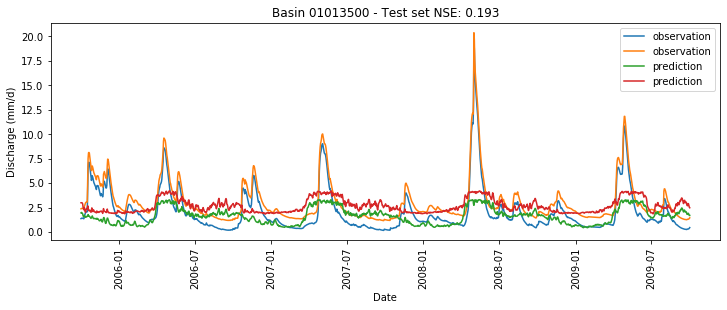

In [149]:
obs, preds = eval_model(model, test_loader)
preds = ds_val.local_rescale(preds.numpy(), variable='output')
obs = obs.numpy()
nse = calc_nse(obs, preds)

# Plot results
start_date = ds_test.dates[0]
end_date = ds_test.dates[1] + pd.DateOffset(days=1)
date_range = pd.date_range(start_date, end_date)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(date_range, obs, label="observation")
ax.plot(date_range, preds, label="prediction")
ax.legend()
ax.set_title(f"Basin {basin} - Test set NSE: {nse:.3f}")
ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel("Date")
_ = ax.set_ylabel("Discharge (mm/d)")